# TP2: Régression Polynômiale à plusieurs variables

**Objectif :**
Implémenter un modèle de régression polynomiale à un dataset pour prédire une variable cible.

Vous utilisez les données apportées depuis un fichier `land_annual_temperature.csv`.

**Étapes du TP :**
1. Importer les librairies.
2. Importer le dataset (et le nettoyer).
3. Visualiser les données initiales.
4. Implémenter la régression linéaire simple, calculer son coefficient de détermination R², et visualiser son ajustement.
5. Implémenter la régression polynomiale (degré 3), calculer son coefficient de détermination R², et visualiser son ajustement.
6. Comparer les deux coefficients de détermination.
7. Effectuer des prédictions pour l'année 2021 avec les deux modèles.
8. Visualiser les résultats comparatifs des deux modèles, y compris les prédictions.

## 1. Importer les librairies

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

## 2. Importer le dataset
Nous allons charger le fichier `land_annual_temperature.csv`, vérifier les valeurs manquantes et invalides, puis renommer les colonnes pour une manipulation plus aisée.

In [75]:
try:
    # Lire le fichier CSV
    df = pd.read_csv('land_annual_temperature.csv', sep=';')
    print("Dataset initialement chargé.")

    # Vérifier les valeurs manquantes
    if df.isnull().any().any():
        print("\nAvertissement: Le dataset contient des valeurs manquantes.")
        print("Nombre de valeurs manquantes par colonne:")
        print(df.isnull().sum())
        print("\nSuppression des lignes avec des valeurs manquantes...")
        df = df.dropna()
        print(f"Lignes restantes: {len(df)}")
    else:
        print("\nLe dataset ne contient pas de valeurs manquantes initiales.")

    # Valider les données numériques
    df_original_cols = df.columns.tolist() # Stocker les noms des colonnes originales
    for column in df_original_cols:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    # Supprimer les lignes contenant des NaN après la conversion
    initial_len = len(df)
    df = df.dropna()
    if len(df) < initial_len:
        print(f"\n{initial_len - len(df)} lignes supprimées contenant des valeurs numériques invalides après conversion.")
    else:
        print("\nAucune ligne supprimée en raison de valeurs numériques invalides après conversion.")

    if len(df) == 0:
        raise ValueError("Aucune donnée valide ne reste après le nettoyage")
    
    print("\nDataset chargé et nettoyé avec succès.")

except FileNotFoundError:
    print("Erreur: Le fichier 'land_annual_temperature.csv' n'a pas été trouvé. Veuillez vérifier le chemin du fichier et réessayer.")
    df = pd.DataFrame() # Créer un df vide pour éviter les erreurs dans les cellules suivantes
except pd.errors.EmptyDataError:
    print("Erreur: Le fichier est vide.")
    df = pd.DataFrame()
except pd.errors.ParserError:
    print("Erreur: Impossible de lire le fichier CSV. Veuillez vérifier le format du fichier et le séparateur.")
    df = pd.DataFrame()
except Exception as e:
    print(f"Une erreur inattendue est survenue: {e}")
    df = pd.DataFrame()

Dataset initialement chargé.

Le dataset ne contient pas de valeurs manquantes initiales.

Aucune ligne supprimée en raison de valeurs numériques invalides après conversion.

Dataset chargé et nettoyé avec succès.


### Aperçu et Informations sur le dataset

In [76]:
if not df.empty:
    print("Aperçu du dataset:")
    print(df.head())
    print("\nInformations sur le dataset:")
    df.info()
else:
    print("Le DataFrame est vide. Impossible d'afficher l'aperçu ou les informations.")

Aperçu du dataset:
   Year  land annual temperature
0  1880                    -0.62
1  1881                    -0.41
2  1882                    -0.50
3  1883                    -0.59
4  1884                    -0.86

Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     139 non-null    int64  
 1   land annual temperature  139 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 2.3 KB


### Renommer les colonnes et vérifier les types de données

In [77]:
if not df.empty:
    df.columns = ['Year', 'Temperature']
    print("Colonnes renommées.")
    
    # S'assurer que les types de données sont corrects après renommage
    df['Year'] = pd.to_numeric(df['Year'])
    df['Temperature'] = pd.to_numeric(df['Temperature'])
    print("\nTypes de données vérifiés après renommage.")
    print("Aperçu après renommage et vérification des types:")
    print(df.head())
    print("\nInformations sur le dataset après renommage et vérification des types:")
    df.info()
else:
    print("Le DataFrame est vide. Impossible de renommer les colonnes ou de vérifier les types.")

Colonnes renommées.

Types de données vérifiés après renommage.
Aperçu après renommage et vérification des types:
   Year  Temperature
0  1880        -0.62
1  1881        -0.41
2  1882        -0.50
3  1883        -0.59
4  1884        -0.86

Informations sur le dataset après renommage et vérification des types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         139 non-null    int64  
 1   Temperature  139 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 2.3 KB


## 3. Visualiser les données

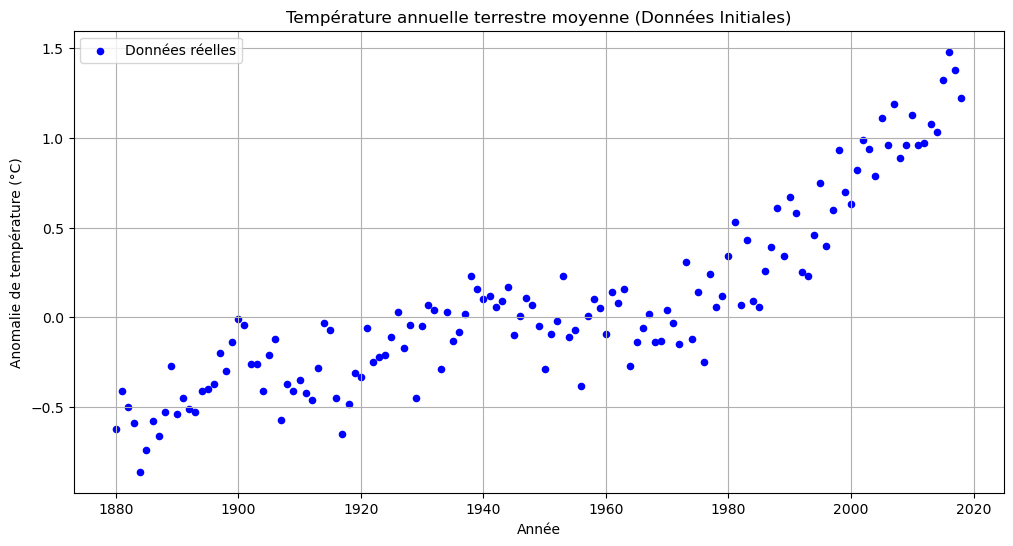

In [78]:
if not df.empty:
    plt.figure(figsize=(12, 6))
    plt.scatter(df['Year'], df['Temperature'], color='blue', label='Données réelles', s=20) # s pour la taille des points
    plt.title('Température annuelle terrestre moyenne (Données Initiales)')
    plt.xlabel('Année')
    plt.ylabel('Anomalie de température (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Le DataFrame est vide. Impossible de visualiser les données.")

### Préparer les données pour Scikit-learn (Variables X et y)

In [79]:
if not df.empty:
    # X doit être un array 2D (DataFrame), y un array 1D (Series)
    X = df[['Year']] # DataFrame avec une colonne
    y = df['Temperature'] # Series
    print(f"Forme de X: {X.shape}")
    print(f"Forme de y: {y.shape}")
    print("\nPremières 5 valeurs de X:")
    print(X.head())
    print("\nPremières 5 valeurs de y:")
    print(y.head())
else:
    print("Le DataFrame est vide. Impossible de préparer les données pour Scikit-learn.")
    # Initialiser X et y pour éviter les erreurs dans les cellules suivantes si df est vide
    X = pd.DataFrame()
    y = pd.Series(dtype='float64')

Forme de X: (139, 1)
Forme de y: (139,)

Premières 5 valeurs de X:
   Year
0  1880
1  1881
2  1882
3  1883
4  1884

Premières 5 valeurs de y:
0   -0.62
1   -0.41
2   -0.50
3   -0.59
4   -0.86
Name: Temperature, dtype: float64


## 4. Implémenter la régression linéaire et Calculer le coefficient de détermination R²

In [80]:
if not X.empty:
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, y)
    print("Modèle de régression linéaire simple entraîné.")
    
    # Prédictions pour le calcul de R²
    y_pred_linear = linear_regressor.predict(X)
    r2_linear = r2_score(y, y_pred_linear)
    print(f"Coefficient de détermination R² (Régression Linéaire): {r2_linear:.4f}")
else:
    print("X est vide. Impossible d'entraîner le régresseur linéaire.")
    linear_regressor = None
    y_pred_linear = np.array([])
    r2_linear = np.nan

Modèle de régression linéaire simple entraîné.
Coefficient de détermination R² (Régression Linéaire): 0.7612


### Visualisation de la Régression Linéaire Simple

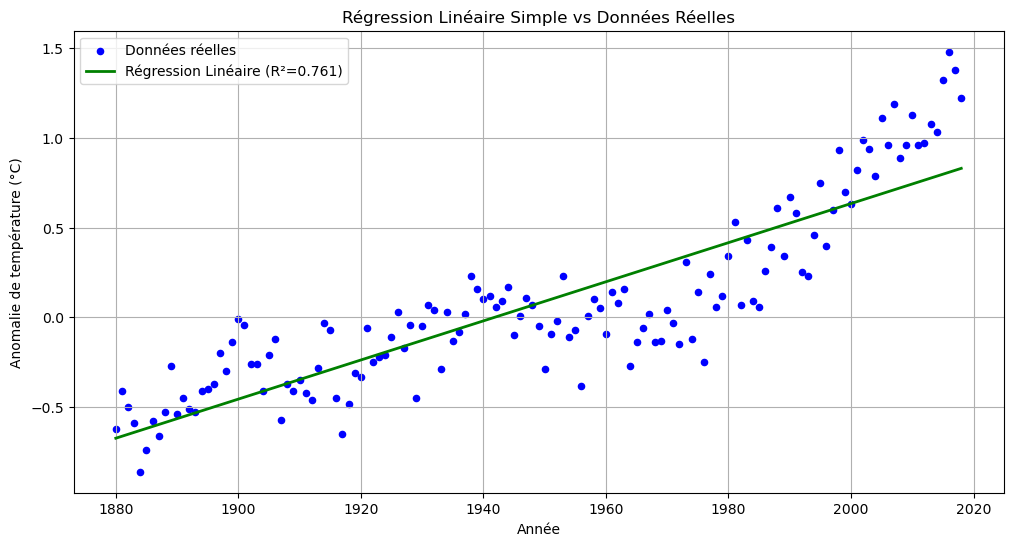

In [81]:
if not X.empty and linear_regressor is not None:
    plt.figure(figsize=(12, 6))
    plt.scatter(X, y, color='blue', label='Données réelles', s=20)
    plt.plot(X, y_pred_linear, color='green', linewidth=2, label=f'Régression Linéaire (R²={r2_linear:.3f})')
    plt.title('Régression Linéaire Simple vs Données Réelles')
    plt.xlabel('Année')
    plt.ylabel('Anomalie de température (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Données ou modèle linéaire non disponibles pour la visualisation.")

## 5. Implémenter la régression polynomiale à plusieurs variables avec le degré 3 et Calculer le coefficient de détermination R²

In [82]:
if not X.empty:
    poly_features = PolynomialFeatures(degree=3, include_bias=False)
    X_poly = poly_features.fit_transform(X)
    print(f"Forme des features polynomiales (degré 3): {X_poly.shape}")
    
    poly_regressor = LinearRegression()
    poly_regressor.fit(X_poly, y)
    print("Modèle de régression polynomiale (degré 3) entraîné.")
    
    y_pred_poly = poly_regressor.predict(X_poly)
    r2_poly = r2_score(y, y_pred_poly)
    print(f"Coefficient de détermination R² (Régression Polynomiale degré 3): {r2_poly:.4f}")
else:
    print("X est vide. Impossible de créer les features polynomiales ou d'entraîner le modèle.")
    X_poly = np.array([])
    poly_features = None
    poly_regressor = None
    y_pred_poly = np.array([])
    r2_poly = np.nan

Forme des features polynomiales (degré 3): (139, 3)
Modèle de régression polynomiale (degré 3) entraîné.
Coefficient de détermination R² (Régression Polynomiale degré 3): 0.8836


### Visualisation de la Régression Polynomiale (Degré 3)

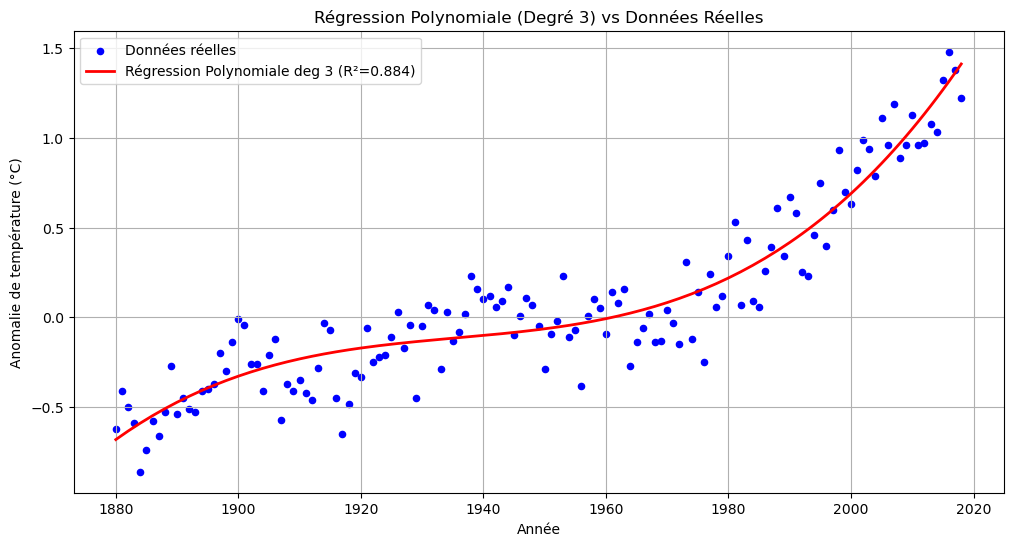

In [83]:
if not X.empty and poly_regressor is not None:
    plt.figure(figsize=(12, 6))
    plt.scatter(X, y, color='blue', label='Données réelles', s=20)
    
    # Pour tracer la courbe, il faut trier X pour que la ligne soit continue
    X_plot_sorted, y_pred_poly_sorted = zip(*sorted(zip(X['Year'], y_pred_poly)))
    plt.plot(X_plot_sorted, y_pred_poly_sorted, color='red', linewidth=2, label=f'Régression Polynomiale deg 3 (R²={r2_poly:.3f})')
    
    plt.title('Régression Polynomiale (Degré 3) vs Données Réelles')
    plt.xlabel('Année')
    plt.ylabel('Anomalie de température (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Données ou modèle polynomial non disponibles pour la visualisation.")

## 6. Comparer les deux coefficients de détermination. Que constatez-vous ?

In [84]:
print("\n--- Comparaison des Coefficients de Détermination R² ---")
if not np.isnan(r2_linear):
    print(f"R² Régression Linéaire: {r2_linear:.4f}")
if not np.isnan(r2_poly):
    print(f"R² Régression Polynomiale (degré 3): {r2_poly:.4f}")

if not (np.isnan(r2_poly) or np.isnan(r2_linear)):
    if r2_poly > r2_linear:
        print("\nConstatation: Le modèle de régression polynomiale (degré 3) a un coefficient R² plus élevé.")
        print("Cela signifie qu'il explique une plus grande proportion de la variance des données de température que le modèle linéaire simple.")
        print("Visuellement, la courbe polynomiale épouse mieux la forme générale des données, suggérant une relation non-linéaire entre l'année et la température.")
    elif r2_poly < r2_linear:
        print("\nConstatation: Le modèle de régression linéaire simple a un coefficient R² plus élevé que le modèle polynomial (degré 3).")
        print("Cela pourrait indiquer que le modèle polynomial de degré 3 est trop complexe (sur-ajustement) pour ces données ou que la relation sous-jacente est mieux capturée par un modèle plus simple.")
    else:
        print("\nConstatation: Les deux modèles ont des coefficients R² très similaires.")
        print("Dans ce cas, le modèle linéaire simple pourrait être préféré pour sa simplicité (principe de parcimonie).")
else:
    print("\nConstatation: Impossible de comparer les R² car un ou plusieurs modèles n'ont pas pu être évalués.")


--- Comparaison des Coefficients de Détermination R² ---
R² Régression Linéaire: 0.7612
R² Régression Polynomiale (degré 3): 0.8836

Constatation: Le modèle de régression polynomiale (degré 3) a un coefficient R² plus élevé.
Cela signifie qu'il explique une plus grande proportion de la variance des données de température que le modèle linéaire simple.
Visuellement, la courbe polynomiale épouse mieux la forme générale des données, suggérant une relation non-linéaire entre l'année et la température.


## 7. Donnez une prédiction température annuelle pour l'année 2021.

In [85]:
year_to_predict = 2021
# Préparer l'année pour la prédiction (doit être un DataFrame 2D pour scikit-learn)
year_array_df = pd.DataFrame([[year_to_predict]], columns=['Year'])
print(f"Année à prédire: {year_to_predict}")

Année à prédire: 2021


### Prédiction avec le modèle linéaire

In [86]:
temp_pred_linear_2021 = np.nan # Initialisation
if linear_regressor:
    temp_pred_linear_2021_arr = linear_regressor.predict(year_array_df)
    temp_pred_linear_2021 = temp_pred_linear_2021_arr[0]
    print(f"Prédiction de température pour {year_to_predict} (Linéaire): {temp_pred_linear_2021:.2f}°C")
else:
    print("Modèle linéaire non disponible pour la prédiction.")

Prédiction de température pour 2021 (Linéaire): 0.86°C


### Prédiction avec le modèle polynomial

In [87]:
temp_pred_poly_2021 = np.nan # Initialisation
if poly_regressor and poly_features:
    year_poly_features_to_predict = poly_features.transform(year_array_df)
    temp_pred_poly_2021_arr = poly_regressor.predict(year_poly_features_to_predict)
    temp_pred_poly_2021 = temp_pred_poly_2021_arr[0]
    print(f"Prédiction de température pour {year_to_predict} (Polynomial degré 3): {temp_pred_poly_2021:.2f}°C")
else:
    print("Modèle polynomial ou features polynomiales non disponibles pour la prédiction.")

Prédiction de température pour 2021 (Polynomial degré 3): 1.57°C


## 8. Visualiser les résultats.
Cette visualisation combine les données réelles, les deux modèles de régression, et les prédictions pour 2021.

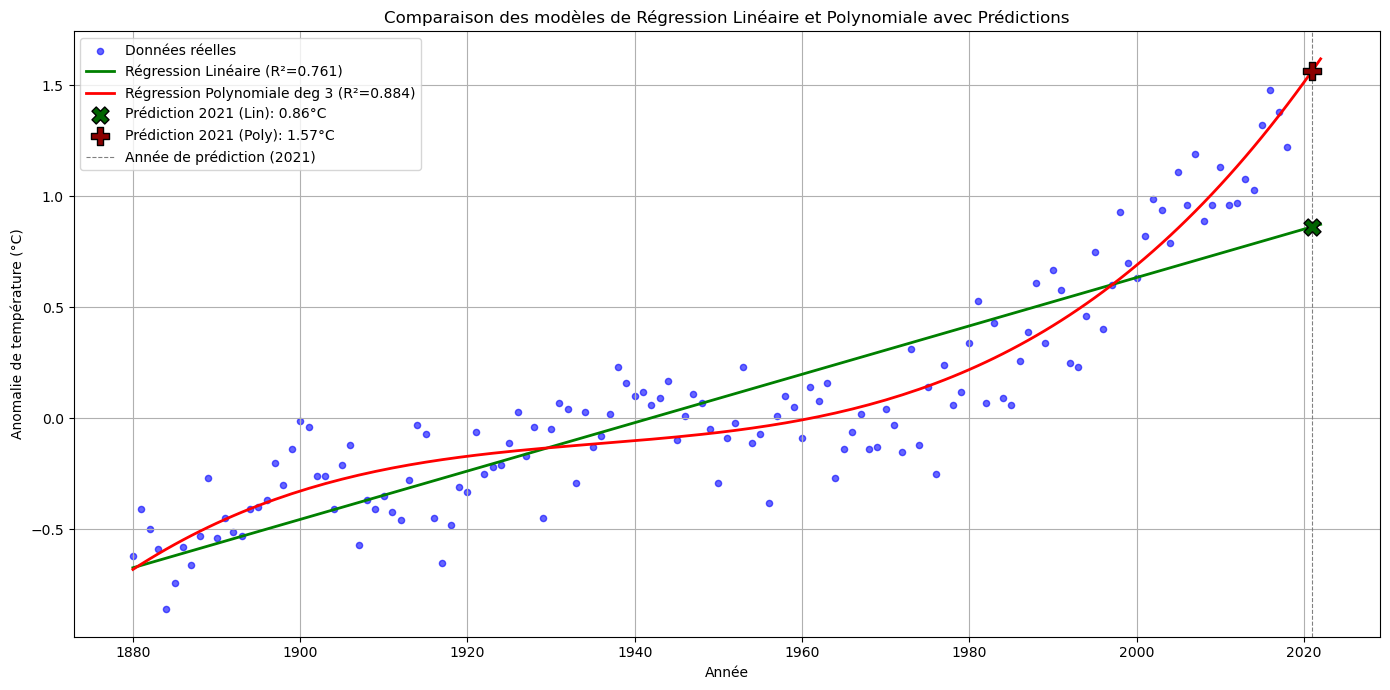

In [88]:
if not df.empty and linear_regressor and poly_regressor and poly_features and not np.isnan(temp_pred_linear_2021) and not np.isnan(temp_pred_poly_2021):
    plt.figure(figsize=(14, 7))
    plt.scatter(df['Year'], df['Temperature'], color='blue', label='Données réelles', s=20, alpha=0.6)
    
    # Générer une plage d'années pour le tracé des lignes de régression, incluant l'année de prédiction
    X_plot_values = np.arange(df['Year'].min(), year_to_predict + 2).reshape(-1, 1) # Étendre un peu au-delà de 2021 pour une meilleure visibilité
    X_plot_df = pd.DataFrame(X_plot_values, columns=['Year']) # DataFrame pour la transformation
    
    # Prédictions pour le tracé du modèle linéaire
    y_plot_linear = linear_regressor.predict(X_plot_df)
    plt.plot(X_plot_values, y_plot_linear, color='green', linewidth=2, label=f'Régression Linéaire (R²={r2_linear:.3f})')
    
    # Prédictions pour le tracé du modèle polynomial
    X_plot_poly_transformed = poly_features.transform(X_plot_df)
    y_plot_poly = poly_regressor.predict(X_plot_poly_transformed)
    plt.plot(X_plot_values, y_plot_poly, color='red', linewidth=2, label=f'Régression Polynomiale deg 3 (R²={r2_poly:.3f})')
    
    # Afficher les prédictions spécifiques pour 2021
    plt.scatter([year_to_predict], [temp_pred_linear_2021], color='darkgreen', marker='X', s=150, label=f'Prédiction 2021 (Lin): {temp_pred_linear_2021:.2f}°C', zorder=5, edgecolors='black')
    plt.scatter([year_to_predict], [temp_pred_poly_2021], color='darkred', marker='P', s=150, label=f'Prédiction 2021 (Poly): {temp_pred_poly_2021:.2f}°C', zorder=5, edgecolors='black')
    
    plt.title('Comparaison des modèles de Régression Linéaire et Polynomiale avec Prédictions')
    plt.xlabel('Année')
    plt.ylabel('Anomalie de température (°C)')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.axvline(x=year_to_predict, color='gray', linestyle='--', linewidth=0.8, label=f'Année de prédiction ({year_to_predict})')
    plt.legend(loc='upper left') # Répéter pour inclure la ligne verticale
    plt.tight_layout()
    plt.show()
else:
    print("Données, modèles ou prédictions non disponibles pour la visualisation finale.")